In [1]:
import numpy as np
import scipy 
import itertools as it
import time

from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, assemble

In [2]:
def Heatsquare(B1=1, B2=1, deg=1, N=3):
    h1, h2 = 1/B1, 1/B2
    geos= [geometry.unit_square().scale((h1,h2)).translate((j*h1,i*h2)) for i,j in it.product(range(B2),range(B1))]
    kvs = B1*B2 *[2* (bspline.make_knots(deg,0,1,N),)]
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches, domains={i:{i} for i in range(B1*B2)})
    M.set_boundary_id({'D':{(B1*B2 - i - 1,1) for i in range(B1)},'N0':{(B1*j,2) for j in range(B2)}|{(B1*j+B1-1,3) for j in range(B2)},'N1':{(i,0) for i in range(B1)}})
    return M

In [24]:
B1,B2 = 10,10
M = Heatsquare(B1,B2,2,20)

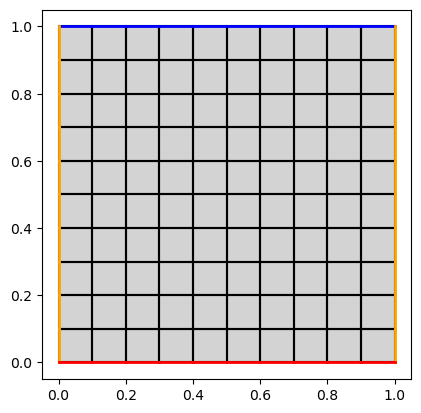

In [25]:
M.draw(knots=1,patch_idx=0, bcolor={'D':'blue','N0':'orange','N1':'red'},bwidth=2)

In [26]:
f = lambda x,y: 0.
g = lambda x,y: 0.
n = lambda x,y: 1.
MP = assemble.Multipatch(M, automatch=True)

dir_bcs = MP.compute_dirichlet_bcs({'D':g})

def create_reduced(Mu):
    N = Mu.shape[1]
    Phi = np.zeros((MP.numdofs,N))

    Aq = np.array([MP.assemble_volume('inner(grad(u),grad(v)) * dx', arity=2, domain_id=k) for k in range(B1*B2)])
    Mq = np.array([MP.assemble_volume('u * v * dx', arity=2, domain_id=k) for k in range(B1*B2)])
    F = MP.assemble_volume(vform.L2functional_vf(2, physical=True), f=f)
    Ne = MP.assemble_surface('(n * v) * ds', arity=1, n=n, boundary_idx='N1')
    I = MP.assemble_surface('v * ds', arity=1, boundary_idx='N1')
    rhs = F + Ne
    
    for j in range(Mu.shape[1]):
        A = Mu[:,j].ravel()@Aq
        LS = assemble.RestrictedLinearSystem(A, rhs, dir_bcs)
        Phi[:,j] = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))
    return Phi, Aq, Mq, rhs, I

setting up constraints took 0.4016284942626953 seconds.
Basis setup took 0.052791595458984375 seconds


In [27]:
# sampling the training set
N = 10
Mu = np.ones((B1*B2,N))
Mu[0,:] = np.linspace(0.5,2,N)

In [28]:
# computing snapshots
Phi, Aq, Mq, F, I = create_reduced(Mu)

In [29]:
# orthonormalization of the basis (euclidean scalar product)
Phi,_ = np.linalg.qr(Phi)

In [30]:
# compute reduced operators
ANq = np.array([Phi.T@A@Phi for A in Aq]).transpose((1,0,2))
FN = Phi.T@F
IN = Phi.T@I

In [46]:
mu=np.ones(B1*B2)
#mu[0] = np.random.rand()*(2-0.5)+0.5
mu[0] = 500
uN = np.linalg.solve(mu@ANq,FN)
u = Phi@uN

In [47]:
LS = assemble.RestrictedLinearSystem(mu@Aq, F, dir_bcs)
u_exact = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))
e = u - u_exact

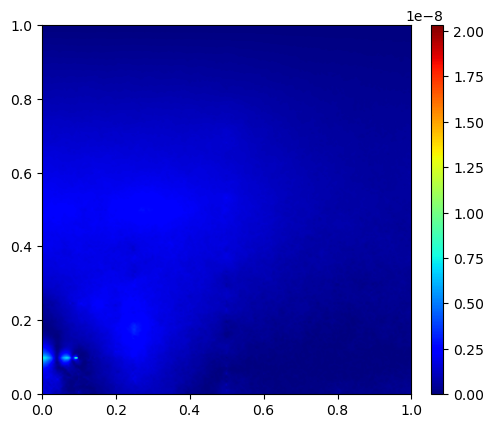

In [48]:
MP.plot(abs(e), cmap='jet')

In [49]:
np.sqrt(e@sum(Aq)@e)

3.3459831934713714e-08

In [50]:
np.sqrt(e@sum(Mq)@e)

1.174635715910617e-09

In [51]:
abs(I@e)

8.131672372494782e-12

In [52]:
IN@uN

0.9861704261891219